# song2pattern

このノートブックを実行することでSpotify APIから情報を取得し、その情報をもとにGray-Scottモデルを用いてパターンを可視化することができます。

In [160]:
import config
import requests
import json

はじめに、Spotify APIの情報を取得する必要があります。下記のサイトから各自のSpotifyアカウント（プレミアムでなくても可能）でログインして、client_idとclient_secretを取得してください。
https://developer.spotify.com/documentation/web-api

In [161]:
client_id = config.client_id # 直接 client_id = 'aaaaaaabbbbbcc'というように入力しても可
client_secret = config.client_secret

In [162]:
data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
}

response = requests.post('https://accounts.spotify.com/api/token', data=data)
user_data = json.loads(response.text)
access_token = user_data['access_token']

In [163]:
def search(search_str):
    headers = {
        'Authorization': 'Bearer '+access_token,
        'Accept-Language': 'ja;q=1',
    }

    response = requests.get(f'https://api.spotify.com/v1/search?q={search_str}&type=track', headers=headers)
    data = json.loads(response.text)
    items = data['tracks']['items']
    
    def get_item_details(item):
        details = {
            'name': item['name'],
            'artist': item['artists'][0]['name'],
            'song_id': item['id'],
            'image_url': item['album']['images'][0]['url']
        }
        return details
    
    items_details = []
    for item in items:
        items_details.append(get_item_details(item))
    
    return items_details

In [164]:
def feature(song_id):
    headers = {
        'Authorization': 'Bearer  '+access_token,
    }

    response = requests.get(f'https://api.spotify.com/v1/audio-features/{song_id}', headers=headers)
    return json.loads(response.text)

以上の、search関数により曲の検索ができます。feature関数にsearchによって得られたidを引数で渡すことで、曲の特徴情報を得ることができます。

In [165]:
search('ivy')

[{'name': 'Ivy',
  'artist': 'フランク・オーシャン',
  'song_id': '2ZWlPOoWh0626oTaHrnl2a',
  'image_url': 'https://i.scdn.co/image/ab67616d0000b273c5649add07ed3720be9d5526'},
 {'name': 'ivy',
  'artist': 'テイラー・スウィフト',
  'song_id': '19CSr8rwW05VJL2F91KFNK',
  'image_url': 'https://i.scdn.co/image/ab67616d0000b27333b8541201f1ef38941024be'},
 {'name': 'Quiero Bailar',
  'artist': 'Ivy Queen',
  'song_id': '7mY1dIaY9vY6Jrlrjg3dRn',
  'image_url': 'https://i.scdn.co/image/ab67616d0000b273774ca12732a1ae8541a45b5b'},
 {'name': 'ivy',
  'artist': 'テイラー・スウィフト',
  'song_id': '7tXMHAFEOzcUaUQqovRGho',
  'image_url': 'https://i.scdn.co/image/ab67616d0000b27325751b4b32829d6bbfe6be7f'},
 {'name': 'CELEBRANDO',
  'artist': 'Rauw Alejandro',
  'song_id': '4KrNCWx08dZr11kGIUHuuX',
  'image_url': 'https://i.scdn.co/image/ab67616d0000b273f29d0900444e44b4146409e5'},
 {'name': 'Ivy',
  'artist': 'Luca Longobardi',
  'song_id': '1vkyQxqSUp9P83q1JnQit9',
  'image_url': 'https://i.scdn.co/image/ab67616d0000b273044b46c

In [166]:
feature('2ZWlPOoWh0626oTaHrnl2a') # Ivy

{'danceability': 0.575,
 'energy': 0.386,
 'key': 9,
 'loudness': -9.584,
 'mode': 0,
 'speechiness': 0.037,
 'acousticness': 0.785,
 'instrumentalness': 0.000289,
 'liveness': 0.229,
 'valence': 0.466,
 'tempo': 116.408,
 'type': 'audio_features',
 'id': '2ZWlPOoWh0626oTaHrnl2a',
 'uri': 'spotify:track:2ZWlPOoWh0626oTaHrnl2a',
 'track_href': 'https://api.spotify.com/v1/tracks/2ZWlPOoWh0626oTaHrnl2a',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2ZWlPOoWh0626oTaHrnl2a',
 'duration_ms': 249191,
 'time_signature': 4}

In [6]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
import random

jitによる処理の高速化などは、以下を参考にしました。

https://qiita.com/kaityo256/items/3c07252ab63591256835

peason分類については、以下を参考にしました。これにより、模様を観測できるfeed_rateとkill_rateの組み合わせを割り出すことができます。

http://mrob.com/pub/comp/xmorphia/pearson-classes.html

In [7]:
peason_class = [
    (0.010, 0.047),
    (0.014, 0.053),
    (0.014, 0.039),
    (0.026, 0.051),
    (0.022, 0.051),
    (0.026, 0.055),
    (0.030, 0.055),
    (0.042, 0.059),
    (0.018, 0.055),
    (0.022, 0.059),
    (0.026, 0.059),
    (0.034, 0.063),
    (0.030, 0.057),
    (0.038, 0.061),
    (0.046, 0.0594),
    (0.050, 0.063),
    (0.058, 0.063),
    (0.026, 0.061),
    (0.034, 0.065),
    (0.046, 0.065),
    (0.058, 0.065),
    (0.014, 0.047),
]

In [167]:
peason_feeds = []
peason_r = []

for i in peason_class:
    peason_feeds.append(i[0])
    peason_r.append(i[0]/i[1])

In [12]:
du = 2e-5
dv = 1e-5
dx = 0.01
dt = 1

@jit
def laplacian(ix, iy, s):
    ts = 0.0
    ts += s[ix-1, iy]
    ts += s[ix+1, iy]
    ts += s[ix, iy-1]
    ts += s[ix, iy+1]
    ts -= 4.0*s[ix, iy]
    ts = ts/(dx*dx)
    return ts


@jit
def calc(u, v, u2, v2, F, k):
    (L, _) = u.shape
    lu = np.zeros((L, L))
    lv = np.zeros((L, L))
    for ix in range(1, L-1):
        for iy in range(1, L-1):
            lu[ix, iy] = du * laplacian(ix, iy, u)
            lv[ix, iy] = dv * laplacian(ix, iy, v)
    cu = -v*v*u + F*(1.0 - u)
    cv = v*v*u - (F+k)*v
    u2[:] = u + (lu+cu) * dt
    v2[:] = v + (lv+cv) * dt

@jit
def boundary(u, v):
    (L, _) = u.shape
    for j in range(L):
        i = j + 1
        n = L - 2
        u[i][0] = u[i][n]
        u[i][n+1] = u[i][1]
        u[0][i] = u[n][i]
        u[n+1][i] = u[1][i]

        v[i][0] = v[i][n]
        v[i][n+1] = v[i][1]
        v[0][i] = v[n][i]
        v[n+1][i] = v[1][i]


def gray_scott(classification, cmap_str, init_vertex, randomness, song_name):
    F = peason_class[classification][0]
    k = peason_class[classification][1]
    print(F, k)
    L = 200
    u = np.ones((L, L))
    u2 = np.ones((L, L))
    v = np.zeros((L, L))
    v2 = np.zeros((L, L))
    h = L//2
    u[h, h] = 0.5 + random.random() * 0.1
    v[h, h] = 0.25 + random.random() * 0.1
    for i in range(20):
        for j in range(20):
            start = h-11
            u[start+i, start+j] = 0.5 + random.random() * 0.2 * randomness
            v[start+i, start+j] = 0.25 + random.random() * 0.2 * randomness
    for i in range(10000):
        if i % 2 == 0:
            boundary(u, v)
            calc(u, v, u2, v2, F, k)
        else:
            boundary(u2, v2)
            calc(u2, v2, u, v, F, k)

    plt.imshow(u, cmap=cmap_str)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
    plt.savefig(f"out/{song_name}.png")
    plt.show()

↑のgray_scott関数によって、pythonでgray scottの時間発展を1万回分計算し、プロットすることができます

In [13]:
def download_image(url, song_name):
    file_name = f"out/{song_name}_cover.jpg"

    response = requests.get(url)
    image = response.content

    with open(file_name, "wb") as aaa:
        aaa.write(image)

In [169]:
def song2pattern(song_id, song_name):
    song_feature = feature(song_id)

    danceability = song_feature['danceability']
    time_signature = song_feature['time_signature']
    energy = song_feature['energy']
    acousticness = song_feature['acousticness']
    valence = song_feature['valence']
    
    feed = energy * 0.06
    kill = (1 - acousticness) * 0.065
    
    feed_r = feed / kill
    
    def find_nearest_indices(lst, target):
        indices = sorted(range(len(lst)), key=lambda i: abs(lst[i] - target))[:3]
        return indices
    
    near_indices = find_nearest_indices(peason_feeds, feed)
    
    r_temp = []
    for i in near_indices:
        r_temp.append(peason_r[i])
        
    r_max = max(r_temp)
    r_max_index = peason_r.index(r_max)
    
    print(f'type: {r_max_index}')
    
    randomness = 1 - danceability
    if danceability > 0.9:
        randomness = 0
    
    cmap_str = 'YlGnBu'
    if valence > 0.8:
        cmap_str = 'YlOrBr'
    elif valence > 0.6:
        cmap_str = 'YlGn'
    elif valence > 0.4:
        cmap_str = 'YlGnBu'
    elif valence > 0.2:
        cmap_str = 'viridis'
    else:
        cmap_str = 'bone'

    gray_scott(r_max_index, cmap_str, time_signature, randomness, song_name)

In [170]:
def collect_data(item):
    name = item['name']
    song_id = item['song_id']
    image_url = item['image_url']
    
    print(name)
    
    download_image(image_url, name)
    song2pattern(song_id, name)

In [171]:
search_results = search('ここに検索文字列を入力')
search_results

KeyboardInterrupt: 

type: 2
0.014 0.039


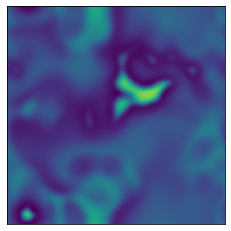

In [158]:
collect_data(search_results[0])